# 🧹 Step 2 : NLP Preprocessing

**Objectif**: Nettoyer et préparer les textes pour les analyses NLP

**Pipeline de prétraitement**:
1. Chargement des textes extraits (Étape 1)
2. Tokenisation (découpage en mots)
3. Nettoyage avancé (ponctuation, nombres, emails, URLs)
4. Suppression des stopwords (+ custom stoplist)
5. Lemmatisation (forme canonique des mots)
6. Création du corpus propre
7. Sauvegarde des résultats

**Output**: Textes prêts pour l'analyse lexicale et topic modeling

## 🔧 Setup Config & Imports

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Imports
import json
import re
from pathlib import Path
from collections import Counter
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP librairies
import nltk
import spacy
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Visualization librairies
from wordcloud import WordCloud

# Progress bar
from tqdm.notebook import tqdm

# Viz Config
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports")

✅ Imports


## 📥 Download NLP resources

In [2]:
# Check and download NLTK resources
nltk_resources = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'omw-1.4']

print("📚 Check NLTK resources...")
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        print(f"  Downloading {resource}...")
        nltk.download(resource, quiet=True)

print("✅ NLTK resources ready")

📚 Check NLTK resources...
✅ NLTK resources ready


In [3]:
# Load spaCy model
print("\n🧠 Load spaCy model...")
try:
    nlp = spacy.load("en_core_web_sm")
    print("✅ spaCy model loaded")
except OSError:
    print("⚠️ spaCy not found. Try installing...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")
    print("✅ spaCy model downloaded and loaded")


🧠 Load spaCy model...
✅ spaCy model loaded


## 📂 Load data from Step 1

In [4]:
# Define paths
PROJECT_ROOT = Path.cwd().parent
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
TEXTS_DIR = PROCESSED_DATA / "texts"
METADATA_FILE = PROCESSED_DATA / "metadata" / "corpus_metadata.json"

print(f"📁 Texts folder : {TEXTS_DIR}")
print(f"📁 Metadata file : {METADATA_FILE}")

📁 Texts folder : c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\texts
📁 Metadata file : c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\metadata\corpus_metadata.json


In [5]:
# Load metadata
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

print(f"\n✅ {len(metadata)} documents found")

# Load texts
texts = {}
for doc_id in metadata.keys():
    text_file = TEXTS_DIR / f"{doc_id}.txt"
    if text_file.exists():
        with open(text_file, 'r', encoding='utf-8') as f:
            texts[doc_id] = f.read()

print(f"✅ {len(texts)} texts loaded")


✅ 20 documents found
✅ 20 texts loaded


In [6]:
# Sample view
print(f"\n📄 First document: {list(texts.keys())[0]}")
print(f"   Length: {len(texts[list(texts.keys())[0]]):,} characters")


📄 First document: Bain_report_technology_report_2025
   Length: 134,654 characters


## 🔍 Pre-analysis of raw text

In [7]:
# Global stats
total_chars = sum(len(text) for text in texts.values())
total_words_raw = sum(len(text.split()) for text in texts.values())

print(f"\nCharacters     : {total_chars:,}")
print(f"Words (raw)    : {total_words_raw:,}")


Characters     : 1,107,527
Words (raw)    : 136,472


In [8]:
# Sample from first doc
first_doc = texts[list(texts.keys())[0]]
print(first_doc[:500])

Technology Report 2025 AI leaders are extending their edge. Authors and acknowledgments David Crawford, chairman of Bain & Company’s Global Technology, Media, and Telecommunications practice; Anne Hoecker, global leader of the TMT practice; and Dana Aulanier, practice vice president of the TMT practice, prepared this report. Bain Partners Syed Ali, Laurent-Pierre Baculard, Bharat Bansal, Ann Bosche, Peter Bowen, Steven Breeden, Alessandro Cannarsi, Willy Chang, Matthew Crupi, Arjun Dutt, Greg Fi


## 🧹 Cleaning functions

In [9]:
def clean_text(text):
    """
    Clean the text in depth.
    
    Steps:
    1. Convert to lowercase
    2. Remove URLs and emails
    3. Remove numbers
    4. Remove excessive punctuation
    5. Normalize spaces
    """
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove numbers (but keep words with numbers like "ai4business")
    text = re.sub(r'\b\d+\b', '', text)
    
    # Remove special characters and punctuation (keep hyphens and apostrophes)
    text = re.sub(r'[^\w\s\'-]', ' ', text)
    
    # Normalize multiple spaces
    text = re.sub(r'\s+', ' ', text)

    text = re.sub(r"[^a-z\s]", " ", text)  # Force
    
    # Remove leading and trailing spaces
    text = text.strip()
    
    return text

In [13]:
def get_wordnet_pos(treebank_tag):
    """
    Convert POS tag (Treebank) to WordNet style.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [10]:
def tokenize_text(text):
    """
    Tokenize text into words.
    """
    return word_tokenize(text)

In [11]:
def remove_stopwords(tokens, custom_stopwords=None):
    """
    Remove english + custom stopwords.
    
    Args:
        tokens: List of tokens
        custom_stopwords: Set of additional stopwords
    """
    # Stopwords NLTK
    stop_words = set(stopwords.words('english'))
    
    # Add custom stopwords
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    
    # Filter
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 2 and token.isalpha()]  ## isalpha() to remove numbers
    
    return filtered_tokens

In [14]:
def lemmatize_tokens(tokens, method='spacy'):
    """
    Lemmatize tokens.
    
    Args:
        tokens: List of tokens
        method: 'spacy' (default) or 'nltk'
    """
    if method == 'spacy':
        # Join for spaCy processing
        text = ' '.join(tokens)
        doc = nlp(text)
        lemmatized = [token.lemma_ for token in doc]
    else:
        # NLTK (easier but less precise)
        lemmatizer = WordNetLemmatizer()

        # POS Tagging
        tagged = pos_tag(tokens)

        lemmatized = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos)) for token, pos in tagged]
    
    return lemmatized

In [15]:
def preprocess_document(text, custom_stopwords=None, use_lemma=True):
    """
    Preprocessing pipeline for a document.
    
    Args:
        text (str): Text to preprocess
        custom_stopwords (list, optional): List of custom stopwords
        use_lemma (bool, optional): Whether to use lemmatisation
    
    Returns:
        dict with cleaned text and processed tokens
    """
    # 1. Cleaning
    cleaned = clean_text(text)
    
    # 2. Tokenization
    tokens = tokenize_text(cleaned)
    
    # 3. Stopwords removal
    filtered = remove_stopwords(tokens, custom_stopwords)    
    
    # 4. Lemmatization
    if use_lemma:
        processed = lemmatize_tokens(filtered, method='spacy')
    else:
        processed = filtered
    
    return {
        'cleaned_text': cleaned,
        'tokens': processed,
        'token_count': len(processed)
    }

## 📝 Define Custom Stopwords

In [ ]:
# Custom stopwords
CUSTOM_STOPWORDS = {
    # Consulting jargon
    'executive', 'summary', 'introduction', 'conclusion', 'chapter', 'section',
    'figure', 'table', 'appendix', 'page', 'report', 'study', 'analysis',
    
    # Mots génériques trop fréquents
    'may', 'will', 'can', 'could', 'would', 'should', 'use', 'make', 'get',
    'also', 'well', 'however', 'therefore', 'moreover', 'furthermore',
    
    # Abréviations courantes
    'et', 'al', 'inc', 'ltd', 'corp', 'eg', 'ie', 'etc',
    
    # Nombres écrits
    'one', 'two', 'three', 'first', 'second', 'third',
    
    # Années (si non pertinentes)
    # '2023', '2024', '2025'  # Décommenter si tu veux les enlever

    # Addings
    'cid', 'new', 'datum', 'across', 'many', 'must',
    'aaron'
}

print(f"🚫 {len(CUSTOM_STOPWORDS)} custom stopwords")
print(f"\nExamples: {list(CUSTOM_STOPWORDS)[:10]}")

🚫 48 custom stopwords

Examples: ['executive', 'ltd', 'would', 'however', 'et', 'two', 'section', 'figure', 'one', 'conclusion']


## 🔄 Corpus preprocessing

In [66]:
processed_corpus = {}

# Progress bar
for doc_id in tqdm(texts.keys(), desc="Preprocessing documents"):
    result = preprocess_document(
        texts[doc_id], 
        custom_stopwords=CUSTOM_STOPWORDS,
        use_lemma=True
    )
    
    processed_corpus[doc_id] = result

print(f"\n✅ {len(processed_corpus)} preprocessed docs")

Preprocessing documents:   0%|          | 0/20 [00:00<?, ?it/s]


✅ 20 preprocessed docs


## 📊 Post-Preprocessing Stats

In [67]:
# Count tokens per document
token_counts = {doc_id: data['token_count'] 
                for doc_id, data in processed_corpus.items()}

# Global Stats
total_tokens = sum(token_counts.values())
avg_tokens = np.mean(list(token_counts.values()))
median_tokens = np.median(list(token_counts.values()))

print(f"\nTotal tokens (post-cleaning) : {total_tokens:,}")
print(f"Average tokens/document      : {avg_tokens:,.0f}")
print(f"Median tokens/document       : {median_tokens:,.0f}")


Total tokens (post-cleaning) : 84,812
Average tokens/document      : 4,241
Median tokens/document       : 2,811


In [68]:
# Reduction ratio
reduction = ((total_words_raw - total_tokens) / total_words_raw) * 100
print(f"\nReduction vs. raw text          : {reduction:.1f}%")


Reduction vs. raw text          : 37.9%


In [69]:
# Top docs by size
print("TOP 5 DOCUMENTS BY TOKENS COUNT")

sorted_docs = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
for i, (doc_id, count) in enumerate(sorted_docs[:5], 1):
    filename = metadata[doc_id]['filename']
    print(f"{i}. {filename[:40]:40} : {count:,} tokens")

TOP 5 DOCUMENTS BY TOKENS COUNT
1. Google_Agentic_AI_TAM_Analysis_2025.pdf  : 14,712 tokens
2. Bain_report_technology_report_2025.pdf   : 12,055 tokens
3. WEF_AI_Agents_in_Action_Foundations_for_ : 7,445 tokens
4. MIT_The_Emerging_Agentic_enterprise_2025 : 6,649 tokens
5. OpenAI_Practices_for_Governing_Agentic_A : 6,403 tokens


## 📈 Stats Visualization

In [70]:
# Create DataFrame for analysis
df_stats = pd.DataFrame({
    'document_id': list(token_counts.keys()),
    'token_count': list(token_counts.values())
})

# Add metadata
df_stats['filename'] = df_stats['document_id'].map(
    lambda x: metadata[x]['filename']
)
df_stats['source_type'] = df_stats['document_id'].map(
    lambda x: metadata[x]['source_type']
)
df_stats['word_count_raw'] = df_stats['document_id'].map(
    lambda x: metadata[x]['word_count']
)

In [71]:
# Compute red by doc
df_stats['reduction_pct'] = (
    (df_stats['word_count_raw'] - df_stats['token_count']) / 
    df_stats['word_count_raw'] * 100
)

In [72]:
df_stats[['filename', 'token_count', 'reduction_pct']].head()

,filename,token_count,reduction_pct
0,Bain_report_technology_report_2025.pdf,12055,41.460691
1,BCG_AI_Agents_2025.pdf,943,41.099313
2,Deloitte_The_business_imperative_for_Agentic_A...,2215,44.150277
3,Google_Agentic_AI_TAM_Analysis_2025.pdf,14712,33.550136
4,Google_The_ROI_of_AI_2025.pdf,753,37.973641


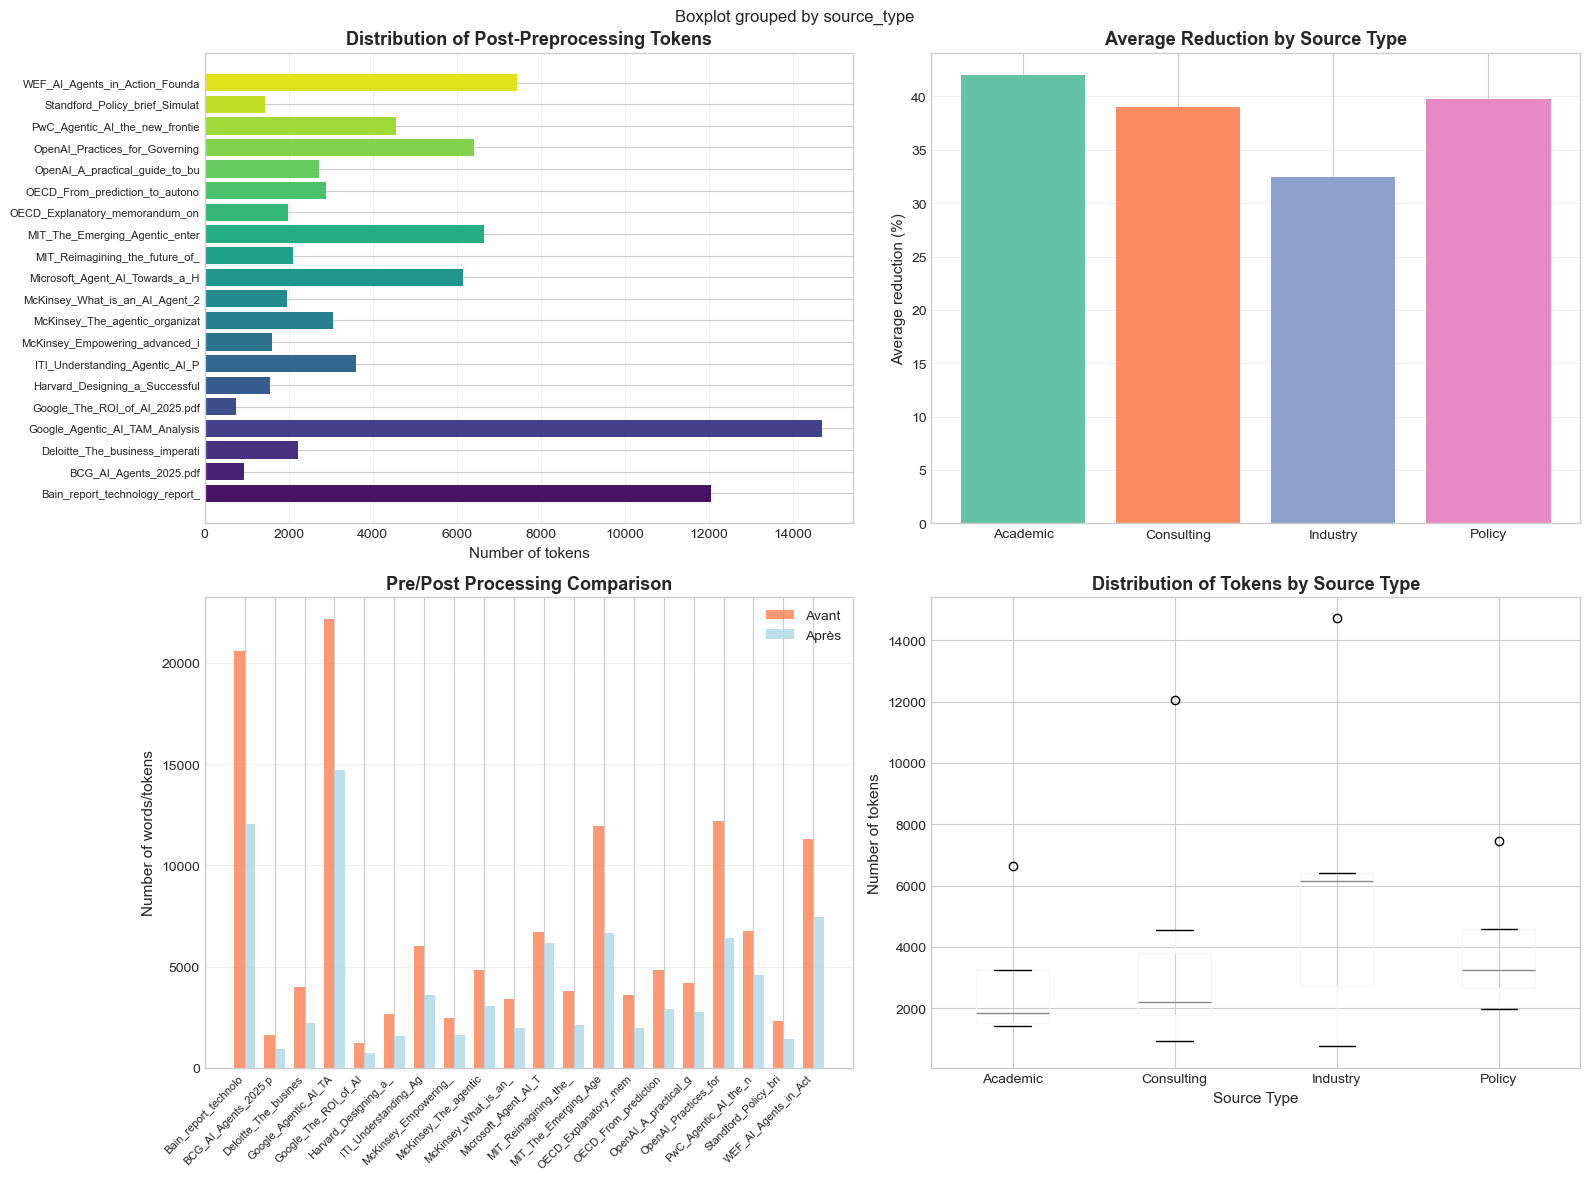


💾 Graphs saved: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\preprocessing_stats.png


In [73]:
# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution des tokens par document
axes[0, 0].barh(
    range(len(df_stats)), 
    df_stats['token_count'],
    color=sns.color_palette("viridis", len(df_stats))
)
axes[0, 0].set_yticks(range(len(df_stats)))
axes[0, 0].set_yticklabels(df_stats['filename'].str[:30], fontsize=8)
axes[0, 0].set_xlabel('Number of tokens', fontsize=11)
axes[0, 0].set_title('Distribution of Post-Preprocessing Tokens', 
                     fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Réduction par type de source
reduction_by_type = df_stats.groupby('source_type')['reduction_pct'].mean()
colors = sns.color_palette('Set2', len(reduction_by_type))
axes[0, 1].bar(reduction_by_type.index, reduction_by_type.values, color=colors)
axes[0, 1].set_ylabel('Average reduction (%)', fontsize=11)
axes[0, 1].set_title('Average Reduction by Source Type', 
                     fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Avant/Après pour chaque document
x = np.arange(len(df_stats))
width = 0.35
axes[1, 0].bar(x - width/2, df_stats['word_count_raw'], width, 
               label='Avant', alpha=0.8, color='coral')
axes[1, 0].bar(x + width/2, df_stats['token_count'], width, 
               label='Après', alpha=0.8, color='lightblue')
axes[1, 0].set_ylabel('Number of words/tokens', fontsize=11)
axes[1, 0].set_title('Pre/Post Processing Comparison', 
                     fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(df_stats['filename'].str[:20], 
                           rotation=45, ha='right', fontsize=8)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Boxplot par type de source
df_stats.boxplot(column='token_count', by='source_type', ax=axes[1, 1])
axes[1, 1].set_xlabel('Source Type', fontsize=11)
axes[1, 1].set_ylabel('Number of tokens', fontsize=11)
axes[1, 1].set_title('Distribution of Tokens by Source Type', 
                     fontsize=13, fontweight='bold')
plt.sca(axes[1, 1])
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig(PROCESSED_DATA / 'preprocessing_stats.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Graphs saved: {PROCESSED_DATA / 'preprocessing_stats.png'}")

## 🔤 Vocabulary Analysis

In [74]:
# Create global vocabulary
all_tokens = []
for doc_data in processed_corpus.values():
    all_tokens.extend(doc_data['tokens'])

# Frequency count
token_freq = Counter(all_tokens)
vocab_size = len(token_freq)

print(f"\nVocabulary size           : {vocab_size:,} unique words")
print(f"Total tokens (occurrences): {len(all_tokens):,}")


Vocabulary size           : 10,097 unique words
Total tokens (occurrences): 84,812


In [75]:
# Top 30 most freq
print("TOP 30 MOST FREQUENT WORDS")
for i, (word, count) in enumerate(token_freq.most_common(30), 1):
    print(f"{i:2}. {word:20} : {count:,} occurrences")

TOP 30 MOST FREQUENT WORDS
 1. agent                : 1,885 occurrences
 2. agentic              : 1,293 occurrences
 3. system               : 1,079 occurrences
 4. human                : 508 occurrences
 5. model                : 499 occurrences
 6. datum                : 480 occurrences
 7. task                 : 420 occurrences
 8. risk                 : 375 occurrences
 9. technology           : 369 occurrences
10. value                : 362 occurrences
11. customer             : 357 occurrences
12. organization         : 348 occurrences
13. process              : 331 occurrences
14. tool                 : 326 occurrences
15. service              : 321 occurrences
16. business             : 305 occurrences
17. time                 : 293 occurrences
18. workflow             : 293 occurrences
19. company              : 270 occurrences
20. user                 : 268 occurrences
21. base                 : 251 occurrences
22. work                 : 248 occurrences
23. need             

## ☁️ Global vocabulary wordcloud

In [76]:
# Create corpus WordCloud
wordcloud = WordCloud(
    width=1600, 
    height=800,
    background_color='white',
    colormap='viridis',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate_from_frequencies(token_freq)

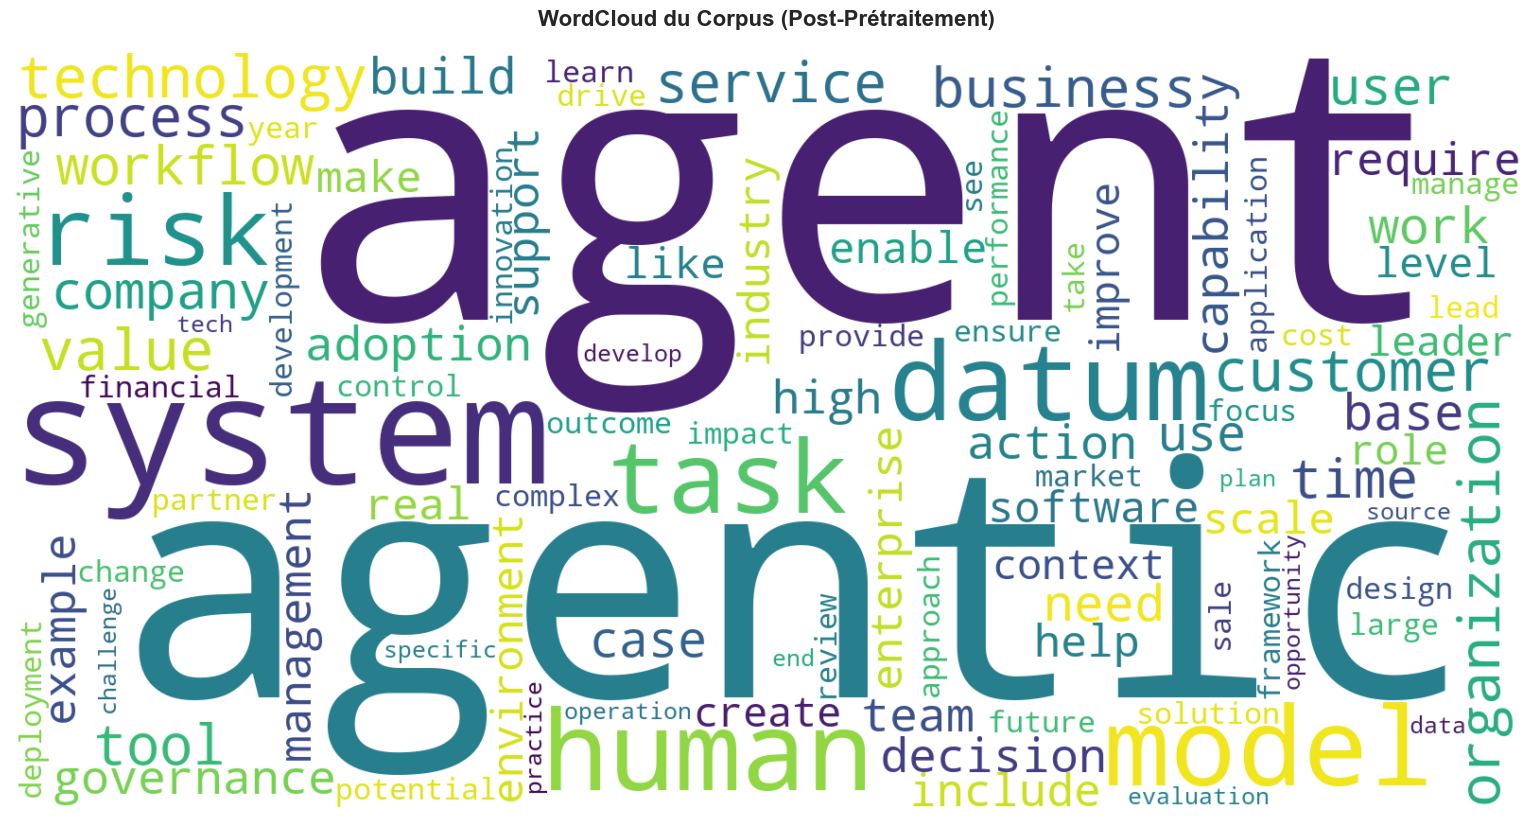

💾 Corpus WordCloud saved: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\wordcloud_corpus.png


In [77]:
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud du Corpus (Post-Prétraitement)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.savefig(PROCESSED_DATA / 'wordcloud_corpus.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Corpus WordCloud saved: {PROCESSED_DATA / 'wordcloud_corpus.png'}")

## 💾 Save results

In [78]:
# Save cleaned texts (1 file/doc)
CLEANED_DIR = PROCESSED_DATA / "cleaned_texts"
CLEANED_DIR.mkdir(exist_ok=True)

for doc_id, doc_data in processed_corpus.items():
    output_file = CLEANED_DIR / f"{doc_id}_cleaned.txt"
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(doc_data['cleaned_text'])

print(f"✅ Cleaned texts saved to: {CLEANED_DIR}")

✅ Cleaned texts saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\cleaned_texts


In [79]:
# Save tokens (1 file/doc)
TOKENS_DIR = PROCESSED_DATA / "tokens"
TOKENS_DIR.mkdir(exist_ok=True)

for doc_id, doc_data in processed_corpus.items():
    output_file = TOKENS_DIR / f"{doc_id}_tokens.txt"
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(doc_data['tokens']))

print(f"✅ Tokens saved to: {TOKENS_DIR}")

✅ Tokens saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\tokens


In [80]:
# Save corpus
corpus_file = PROCESSED_DATA / "preprocessed_corpus.pkl"
with open(corpus_file, 'wb') as f:
    pickle.dump(processed_corpus, f)

print(f"✅ Corpus (pickle): {corpus_file}")

✅ Corpus (pickle): c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\preprocessed_corpus.pkl


In [81]:
# Save stats in CSV format
stats_file = PROCESSED_DATA / "preprocessing_statistics.csv"
df_stats.to_csv(stats_file, index=False, encoding='utf-8')

print(f"✅ Stats csv: {stats_file}")

✅ Stats csv: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\preprocessing_statistics.csv


In [82]:
# Save vocabulary + frequency
vocab_file = PROCESSED_DATA / "vocabulary_frequencies.json"
vocab_data = {
    'vocab_size': vocab_size,
    'total_tokens': len(all_tokens),
    'top_100_words': dict(token_freq.most_common(100))
}
with open(vocab_file, 'w', encoding='utf-8') as f:
    json.dump(vocab_data, f, indent=2, ensure_ascii=False)

print(f"✅ Vocabulary and frequency: {vocab_file}")

✅ Vocabulary and frequency: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\vocabulary_frequencies.json


## 🔍 Prepocess quality validation

In [40]:
checks = []

# Cleaned all docs ?
if len(processed_corpus) == len(texts):
    checks.append("✅ All documents processed")
else:
    checks.append(f"⚠️ Only {len(processed_corpus)}/{len(texts)} cleaned")

# Tokens ?
min_tokens = min(token_counts.values())
if min_tokens > 50:
    checks.append(f"✅ All documents have > 50 tokens (min: {min_tokens})")
else:
    checks.append(f"⚠️ Some documents have < 50 tokens (min: {min_tokens})")

# Reasonable vocabulary size ?
if 1000 < vocab_size < 20000:
    checks.append(f"✅ Reasonable vocabulary size ({vocab_size:,})")
else:
    checks.append(f"⚠️ Unusual vocabulary size ({vocab_size:,})")

# Reasonnable reduction ?
if 30 < reduction < 70:
    checks.append(f"✅ Reduction appropriate ({reduction:.1f}%)")
else:
    checks.append(f"⚠️ Reduction not appropriate ({reduction:.1f}%)")

for check in checks:
    print(f"  {check}")

  ✅ All documents processed
  ✅ All documents have > 50 tokens (min: 783)
  ⚠️ Unusual vocabulary size (25,136)
  ✅ Reduction appropriate (38.6%)


## 🔎 Check pre/post sample

In [41]:
sample_doc_id = list(texts.keys())[0]
print(f"SAMPLE: {metadata[sample_doc_id]['filename']}")

# Raw text
print("\n📄 RAW TEXT:")
print(texts[sample_doc_id][:500])

# Cleaned text
print("\n\n🧹 CLEANED TEXT:")
print(processed_corpus[sample_doc_id]['cleaned_text'][:500])

# First 50 tokens
print("\n\n🔤 FIRST 50 TOKENS:")
print(', '.join(processed_corpus[sample_doc_id]['tokens'][:50]))

SAMPLE: Bain_report_technology_report_2025.pdf

📄 RAW TEXT:
Technology Report 2025 AI leaders are extending their edge. Authors and acknowledgments David Crawford, chairman of Bain & Company’s Global Technology, Media, and Telecommunications practice; Anne Hoecker, global leader of the TMT practice; and Dana Aulanier, practice vice president of the TMT practice, prepared this report. Bain Partners Syed Ali, Laurent-Pierre Baculard, Bharat Bansal, Ann Bosche, Peter Bowen, Steven Breeden, Alessandro Cannarsi, Willy Chang, Matthew Crupi, Arjun Dutt, Greg Fi


🧹 CLEANED TEXT:
technology report ai leaders are extending their edge authors and acknowledgments david crawford chairman of bain company s global technology media and telecommunications practice anne hoecker global leader of the tmt practice and dana aulanier practice vice president of the tmt practice prepared this report bain partners syed ali laurent-pierre baculard bharat bansal ann bosche peter bowen steven breeden alessandro c

## 📋 Step 2 summary

**✅ Actions complétées:**
- Nettoyage approfondi du texte (URLs, emails, ponctuation)
- Tokenisation avec NLTK
- Suppression des stopwords (NLTK + custom)
- Lemmatisation avec spaCy
- Génération de statistiques et visualisations
- Sauvegarde de tous les outputs

**📂 Fichiers générés:**
- Textes nettoyés: `data/processed/cleaned_texts/`
- Tokens: `data/processed/tokens/`
- Corpus pickle: `data/processed/preprocessed_corpus.pkl`
- Statistiques: `data/processed/preprocessing_statistics.csv`
- Vocabulaire: `data/processed/vocabulary_frequencies.json`
- Graphiques: `data/processed/preprocessing_stats.png` + WordCloud

**➡️ Prochaine étape:**
- Étape 3: Analyse lexicale (fréquences, TF-IDF, N-grams)

In [42]:
# Summary Step 2
print("STEP 2 FINISHED SUCCESSFULLY!")
print(f"\n📊 Summary:")
print(f"  • Processed documents   : {len(processed_corpus)}")
print(f"  • Unique vocabulary     : {vocab_size:,} words")
print(f"  • Total tokens          : {total_tokens:,}")
print(f"  • Average reduction     : {reduction:.1f}%")
print(f"\n📂 All files saved to: {PROCESSED_DATA}")
print(f"\n➡️ Ready for Step 3: Lexical Analysis (TF-IDF, N-grams)\n")

STEP 2 FINISHED SUCCESSFULLY!

📊 Summary:
  • Processed documents   : 21
  • Unique vocabulary     : 25,136 words
  • Total tokens          : 291,839
  • Average reduction     : 38.6%

📂 All files saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed

➡️ Ready for Step 3: Lexical Analysis (TF-IDF, N-grams)

